# Part 1: Data Preparation

In this section, we prepare the sepsis prediction dataset from Kaggle: 

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import os

Let's download the entire dataset and save them in the folder named ``data`` on our computer!

**Note:** If you have not already installed ``WFDB``, you can do it as follows: 

In [8]:
!pip install kagglehub



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [9]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import os
# Download latest version
path = kagglehub.dataset_download("salikhussaini49/prediction-of-sepsis")

print("Path to dataset files:", path)

Path to dataset files: /home/tired_atlas/.cache/kagglehub/datasets/salikhussaini49/prediction-of-sepsis/versions/2


The sepsis prediction dataset contains patient records in PSV format. Let's explore and load the data files.

In [10]:
# List available PSV files in the dataset
import glob
psv_files = glob.glob(os.path.join(path, '*.psv'))
print(f"Found {len(psv_files)} PSV files")
if psv_files:
    print("Sample files:", psv_files[:5])

Found 0 PSV files


We will load the PSV (pipe-separated values) files from the sepsis prediction dataset. These files contain clinical measurements and outcomes for different patients in the ICU.

In [23]:
# Load all PSV files and concatenate them
df_list = []

# Search for PSV files in patient subdirectories
for patient_id in patients:
    patient_path = os.path.join(path, 'training_setA/training/', patient_id)
    if os.path.isdir(patient_path):
        # Look for PSV files in each patient directory
        for file in os.listdir(patient_path):
            if file.endswith('.psv'):
                psv_file = os.path.join(patient_path, file)
                df_temp = pd.read_csv(psv_file, sep='|')
                df_list.append(df_temp)
                print(f"Loaded {os.path.basename(psv_file)}: {df_temp.shape}")

# Combine all dataframes
if df_list:
    df = pd.concat(df_list, ignore_index=True)
    print(f"\nTotal combined dataset shape: {df.shape}")
    print(f"\nColumn names: {df.columns.tolist()}")
else:
    print("No PSV files found!")

No PSV files found!


Let's explore the dataset and check for missing values and data types:

In [ ]:
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nFirst few rows:")
print(df.head())

types
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

Now let's check the target variable and prepare the data for modeling:

In [ ]:
# Check if there's a sepsis outcome column (usually 'SepsisLabel' or similar)
print("Value counts for target variable:")
if 'SepsisLabel' in df.columns:
    print(df['SepsisLabel'].value_counts())
elif 'Outcome' in df.columns:
    print(df['Outcome'].value_counts())
else:
    print("Available columns:", df.columns.tolist())

Q1. Please complete the code below to handle missing values and prepare features for the model. You should:
1. Remove rows with missing target variable
2. Handle missing values in features (either drop or fill)
3. Select relevant features for prediction

In [ ]:
# Remove rows with missing target variable
if 'SepsisLabel' in df.columns:
    df_clean = df.dropna(subset=['SepsisLabel']).copy()
elif 'Outcome' in df.columns:
    df_clean = df.dropna(subset=['Outcome']).copy()
else:
    df_clean = df.copy()

print(f"Dataset shape after removing missing targets: {df_clean.shape}")

# Handle missing values in features - fill with median
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())

print(f"Missing values after imputation: {df_clean.isnull().sum().sum()}")
print(f"\nDataset shape: {df_clean.shape}")
print(df_clean.describe())

class
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64


Great! We have loaded and cleaned the sepsis prediction dataset. Now it's time to prepare the features and labels for model training.

In [ ]:
from sklearn.preprocessing import StandardScaler

# Separate features and target
if 'SepsisLabel' in df_clean.columns:
    y = df_clean['SepsisLabel'].values
    X = df_clean.drop(columns=['SepsisLabel'])
elif 'Outcome' in df_clean.columns:
    y = df_clean['Outcome'].values
    X = df_clean.drop(columns=['Outcome'])
else:
    print("Target column not found. Please check column names.")
    X = df_clean
    y = None

# Drop non-numeric columns if any
X = X.select_dtypes(include=[np.number])

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape if y is not None else 'N/A'}")
print(f"Target distribution:\n{pd.Series(y).value_counts()}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"\nFeatures after scaling - mean: {X_scaled.mean().mean():.6f}, std: {X_scaled.std().mean():.6f}")

Let's proceed with splitting the data into training and validation sets.

In [ ]:
# Verify the data is ready for splitting
print("Data shapes:")
print(f"X: {X_scaled.shape}")
print(f"y: {y.shape}")
print(f"Target class distribution: {pd.Series(y).value_counts().to_dict()}")

Now let's examine the feature distribution and prepare for model training.

In [ ]:
# Display feature statistics
print("Feature statistics:")
print(f"Number of features: {X_scaled.shape[1]}")
print(f"Feature names: {X_scaled.columns.tolist()[:10]}...")  # Show first 10
print(f"\nSample features for first row:")
print(X_scaled.iloc[0, :5])

+ 3
J 50
N 2700
V 3
~ 8


Now we're ready to split the data into training and validation sets for model development.

Great! The data is now prepared and ready for model training.

# Part 2: Model Development

Let's start the fun part of every machine/deep learning project, model development :) 

 Q3. It is the time to split the prepared dataset into train and validation parts. Please complete the code below using ``train_test_split`` function from ``scikit-learn`` library to split the dataset. 
 
**Note:** Please set only these two parameters of ``train_test_split`` function and leave the rest as default:

``test_size=0.33`` and ``random_state=42``

And name the outputs of the function as: ``X_train``, ``X_validation``, ``y_train``, ``y_validation``

In [ ]:
from sklearn.model_selection import train_test_split

# Remove the initial zero rows that were used for pre-allocation in build_dataset
# and split into train/validation sets as requested.
X_clean = X[1:,:]
Y_clean = Y[1:,:].ravel()

X_train, X_validation, y_train, y_validation = train_test_split(X_clean, Y_clean, test_size=0.33, random_state=42)

print('Shapes:', X_train.shape, X_validation.shape, y_train.shape, y_validation.shape)

Shapes: (73096, 2160) (36003, 2160) (73096,) (36003,)


Before we start to develope a CNN and an LSTM model for classify heart arrhytmia, let's have a baseline dense neural networks (with only two dense layers) to compare the results of CNN and LSTM with it.

If you have not installed tensorflow already, follow one of the following to install it:

1) using simple "pip" install:

``!pip install tensorflow``

2) Open your "Anaconda Prompt" and type in the below command to install:

``conda install -c conda-forge tensorflow``

In [ ]:
import tensorflow 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

model = Sequential()
model.add(Dense(64, activation = 'relu', input_shape = (X_train.shape[1],)))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(rate = 0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(X_train, y_train, batch_size = 32, epochs= 10, verbose = 1)

2025-12-08 14:50:41.625181: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 14:50:41.631868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765201841.640128  134247 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765201841.642849  134247 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765201841.649569  134247 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Epoch 1/10


I0000 00:00:1765201845.866410  143404 service.cc:152] XLA service 0x7f8dc4003b20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765201845.866428  143404 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 5060 Ti, Compute Capability 12.0
2025-12-08 14:50:45.893194: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765201845.985085  143404 cuda_dnn.cc:529] Loaded cuDNN version 91002
2025-12-08 14:50:46.155278: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-08 14:50:46.155308: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-08 14:5

 181/2285 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - accuracy: 0.7578 - loss: 0.5387

I0000 00:00:1765201846.860978  143404 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2253/2285 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.8833 - loss: 0.2983

2025-12-08 14:50:48.957451: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-08 14:50:48.960135: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-08 14:50:48.961145: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-08 14:50:48.961193: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-08 14:50:48.961345: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurio

2285/2285 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9264 - loss: 0.2051
Epoch 2/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9264 - loss: 0.2051
Epoch 2/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step - accuracy: 0.9646 - loss: 0.1142
Epoch 3/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 880us/step - accuracy: 0.9646 - loss: 0.1142
Epoch 3/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - accuracy: 0.9712 - loss: 0.0927
Epoch 4/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - accuracy: 0.9712 - loss: 0.0927
Epoch 4/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 866us/step - accuracy: 0.9748 - loss: 0.0797
Epoch 5/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 866us/step - accuracy: 0.9748 - loss: 0.0797
Epoch 5/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - accuracy: 0.9769 - loss: 0.0735
Epoch 6/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - accuracy: 0.9769 - loss: 0.0735
Epoch 6/10
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 2s 920us/step - accuracy: 0.9794 - loss: 0.0664
Epoch 7/10
2285/2285 ━━━━

Let's check how well our trained model perform on the validation data. 

In [ ]:
from sklearn.metrics import classification_report

y_pred_val = model.predict(X_validation)

threshold = 0.5
print(classification_report(y_validation, y_pred_val>threshold))

 108/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step

2025-12-08 14:51:09.583965: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors


1110/1126 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step

2025-12-08 14:51:10.454806: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-08 14:51:10.457528: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-08 14:51:10.464412: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-08 14:51:10.474474: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors
2025-12-08 14:51:10.502223: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurio

1126/1126 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     24707
         1.0       0.98      0.94      0.96     11296

    accuracy                           0.97     36003
   macro avg       0.98      0.97      0.97     36003
weighted avg       0.97      0.97      0.97     36003

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     24707
         1.0       0.98      0.94      0.96     11296

    accuracy                           0.97     36003
   macro avg       0.98      0.97      0.97     36003
weighted avg       0.97      0.97      0.97     36003



Q3. Now it is your turn to develop a CNN model. Please complete the cosde below to develope a model architecture as below figure:
    
<center>
<img src="fig3.JPG" width="500"/>  
    
 
**Note:** You should set the ``input_shape = (2160, 1)``. This is equal to the length of one heartbeat ($2\times 3 seconds \times 360 Hz = 2060 samples$) 
    
**Important:** It may take a while to train the below CNN model on CPU and that is why only 2 epochs is chosen. You may train it on Google Colab on GPU nodes.

Another important step to do here is to reshape the inputs to be ``[num_samples, interval, feature=1]``. You may notice that unlike image datasets that we had ``feature=3`` representing the three channels (RGB), here we have only 1D time series as inputs.

In [ ]:
X_train_reshaped = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid_reshaped = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))

print(X_train_reshaped.shape)
print(X_valid_reshaped.shape)

(73096, 2160, 1)
(36003, 2160, 1)


In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()
# Simple 1D CNN architecture
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.fit(X_train_reshaped, y_train, batch_size = 32, epochs= 2, verbose = 1)

/home/tired_atlas/miniconda3/envs/AI-Health/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
2283/2285 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9045 - loss: 0.2346

2025-12-08 14:51:25.849860: W external/local_xla/xla/backends/gpu/codegen/triton/fusion_emitter.cc:1240] Triton does not support sm_120 yet. Passing CC 10.0 to avoid spurious "unsupported conversion" errors


2285/2285 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9466 - loss: 0.1467
Epoch 2/2
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.9466 - loss: 0.1467
Epoch 2/2
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9769 - loss: 0.0707
2285/2285 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9769 - loss: 0.0707


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2156, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1078, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1074, 64)       │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 537, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 34368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │     3,436,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,342,493 (39.45 MB)

 Trainable params: 3,447,497 (13.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,894,996 (26.30 MB)

Q4. Please complete the code below to report the performance of the CNN model.

**Note:** Please name the model predictions on the validation data (``X_valid_reshaped``) as: ``y_pred_cnn``!

In [ ]:
from sklearn.metrics import classification_report

# Predict on validation data
y_pred_cnn = model.predict(X_valid_reshaped)

threshold = 0.5
print(classification_report(y_validation, y_pred_cnn>threshold))

1126/1126 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     24707
         1.0       0.98      0.96      0.97     11296

    accuracy                           0.98     36003
   macro avg       0.98      0.98      0.98     36003
weighted avg       0.98      0.98      0.98     36003

              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     24707
         1.0       0.98      0.96      0.97     11296

    accuracy                           0.98     36003
   macro avg       0.98      0.98      0.98     36003
weighted avg       0.98      0.98      0.98     36003



We can also plot a Confusion Matrix for our trained classifier on the validation data! You should use ``confusion_matrix`` method/function from scikit-learn library for this purpose. For more help and see some examples on how to use``confusion_matrix``, please read here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html  

Q5. Please complete the code below for calculating the confusion matrix for the validation data and name it ``cm``.

**Hint:** The confusion matrix sould look like the below:

<center>
<img src="fig5.JPG" width="400"/> 

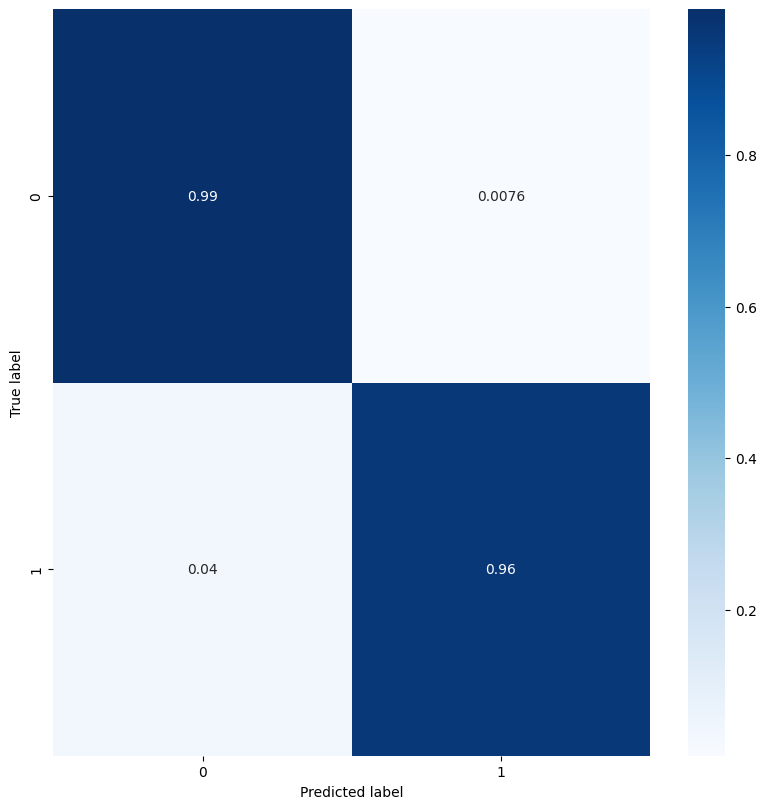

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix for CNN predictions
y_pred_labels = (y_pred_cnn > 0.5).ravel()
cm = confusion_matrix(y_validation, y_pred_labels)
# Normalize the confusion matrix by row (true labels)
cm = cm.astype(float)
cm = cm / cm.sum(axis=1)[:, None]

figure = plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Q6. Now it is time to develop an LSTM model. Please complete the cosde below to develope a model architecture as below figure:
    
<center>
<img src="fig4.JPG" width="500"/>  
    
 
**Note 1:** You should set the ``input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])``. These are equal to the number of samples (heartbeats) and length of one heartbeat ($2\times 3 seconds \times 360 Hz = 2060 samples$). 
    
**Note 2:** The ``return_sequences=True`` force the LSTM/BiLSTM layer to return the output for each LSTM cell/unit.    
    
**Important:** It may take a while to train the below LSTM model on CPU and that is why only 2 epochs is chosen. You may train it on Google Colab on GPU nodes. Here, we reduce the size of the dataset (``X_train_cnn[:10000], y_train[:10000]``) to make it feasible for quick prototyping but you should train the model with the full dataset.

In [ ]:
from tensorflow.keras.layers import Bidirectional, LSTM

model_lstm = Sequential()
# Bidirectional stacked LSTM architecture
model_lstm.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model_lstm.add(Bidirectional(LSTM(32)))
model_lstm.add(Dense(64, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_lstm.fit(X_train_reshaped[:10000], y_train[:10000], batch_size = 32, epochs= 1, verbose = 1)

/home/tired_atlas/miniconda3/envs/AI-Health/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 203ms/step - accuracy: 0.6885 - loss: 0.6202
313/313 ━━━━━━━━━━━━━━━━━━━━ 66s 203ms/step - accuracy: 0.6885 - loss: 0.6202


In [ ]:
model_lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 2160, 128)      │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 237,701 (928.52 KB)

 Trainable params: 79,233 (309.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 158,468 (619.02 KB)

Q7. Please complete the code below to report the performance of the LSTM model.

**Note:** Please name the model predictions on the validation data (``X_valid_reshaped``) as: ``y_pred_lstm``!

In [ ]:
from sklearn.metrics import classification_report

# Predict with the trained LSTM model
y_pred_lstm = model_lstm.predict(X_valid_reshaped)

threshold = 0.5
print(classification_report(y_validation, y_pred_lstm>threshold))

1126/1126 ━━━━━━━━━━━━━━━━━━━━ 109s 97ms/step
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 109s 97ms/step
              precision    recall  f1-score   support

         0.0       0.70      0.98      0.82     24707
         1.0       0.63      0.06      0.11     11296

    accuracy                           0.69     36003
   macro avg       0.66      0.52      0.46     36003
weighted avg       0.67      0.69      0.59     36003

              precision    recall  f1-score   support

         0.0       0.70      0.98      0.82     24707
         1.0       0.63      0.06      0.11     11296

    accuracy                           0.69     36003
   macro avg       0.66      0.52      0.46     36003
weighted avg       0.67      0.69      0.59     36003



# Next Steps

Well done! You have learnt how to develop CNN and LSTM models on real-world time series datasets. But, what can be done to improve our model?


* There are some parameters in the CNN and LSTM models that can be optimized such as:
        1. number of filters in the CNN model.
        2. number of layers in the LSTM model. 


* The model architectures such as number of layers can be explored further to improve the performance.


* We can develop a new model by combining CNN and LSTM layers.


* We can use a completely unseen dataset to test our trained model. For this purpose, two datasets can be used:
        1.MIT-BIH Supraventricular Arrhythmia Database (https://physionet.org/content/svdb/1.0.0/)
        2. St Petersburg INCART 12-lead Arrhythmia Database (https://physionet.org/content/incartdb/1.0.0/)  
        
        
##### So, if you are interested in learning more about time series classification using ECG signals and doing your final report (and/or perhaps your Master thesis) on this topic, please contact me :)  

# Thank you!